In [1]:
%load_ext autoreload
%autoreload 2
%load_ext ipycache

In [2]:
#%%cache -d __cache__/ -f __cache__/eda.pkl eda
# Importing all the required libraries
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, \
                                    StratifiedKFold

from sklearn.metrics import accuracy_score, classification_report
from self_learn import LogisticRegression
from utils import *
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

Every data point corresponds to a (time, latitude, longitude) and contains the following 16 atmospherical variables or features:

TMQ: total (vertically integrated) precipitable water [kg/m^2] <br>
U850: zonal wind at 850 mbar pressure surface [m/s] <br>
V850: meridional wind at 850 mbar pressure surface [m/s] <br>
UBOT: lowest level zonal wind [m/s]<br>
VBOT: lowest model level meridional wind [m/s]<br>
QREFHT: reference height humidity [kg/kg]<br>
PS: surface pressure [Pa]<br>
PSL: sea level pressure [Pa]<br>
T200: temperature at 200 mbar pressure surface [K]<br>
T500: temperature at 500 mbar pressure surface [K]<br>
PRECT: total (convective and large-scale) precipitation rate (liq + ice) [m/s]<br>
TS: surface temperature (radiative) [K]<br>
TREFHT: reference height temperature [K]<br>
Z1000: geopotential Z at 1000 mbar pressure surface [m]<br>
Z200: geopotential Z at 200 mbar pressure surface [m]<br>
ZBOT: lowest modal level height [m]<br>

The training set contains 44,760 data points from 1996 to 2009, each labelled according to one of the following three classes:<br>

0: Standard background conditions<br>
1: Tropical cyclone<br>
2: Atmospheric river<br>

In [3]:
df = pd.read_csv('data/train.csv', parse_dates=['time'],index_col='time').drop(['SNo'], axis=1).sort_index()
print('Set Memory Usage = {:.2f} MB'.format(df.memory_usage().sum() / 1024**2))
display(df.head())

Set Memory Usage = 6.83 MB


,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,Label
time,,,,,,,,,,,,,,,,,,,
1996-06-09,-21.238592,229.6875,25.438482,-3.247382,-3.297787,-3.043154,-1.810961,0.013082,101599.9453,101599.9453,216.035339,264.645508,2.450000e-08,298.454468,297.187134,138.993042,12285.72070,65.412819,2
1996-06-09,12.790091,252.8125,43.837868,5.089389,1.179331,4.618520,0.982055,0.016696,100964.7422,100964.7422,217.971390,266.708191,2.180000e-08,302.191803,300.737671,85.289642,12370.61523,66.320358,0
1996-06-09,12.790091,253.1250,43.696663,5.407827,1.328541,4.925084,1.316138,0.016764,100956.8906,100956.8906,218.071503,266.759705,1.090000e-08,302.217499,300.810516,84.616669,12370.10352,66.336067,0
1996-06-09,-24.758801,241.2500,28.214071,0.229187,0.159589,-0.297387,-2.568464,0.011950,101915.7656,101915.7656,214.134933,263.829346,1.500000e-14,296.791962,295.528748,165.004898,12240.12402,65.012306,2
1996-06-09,-30.391134,353.4375,28.484495,11.346172,0.782980,9.311885,-2.077185,0.009948,102185.5547,102185.5547,214.340439,254.305695,8.200000e-08,292.216675,291.288086,184.840607,11921.95898,63.974442,2


In [4]:
%store df

Stored 'df' (DataFrame)


In [3]:
df.describe()

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,Label
count,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,4.476000e+04,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760,44760.000000
mean,-2.933507,269.270833,34.621980,-0.609818,-0.017271,-2.138797,-0.808013,0.014375,101553.676510,101555.967294,216.829335,264.355844,4.580801e-08,298.344652,296.923570,135.521651,12290.118668,65.384474,2002-05-25 06:37:38.445040256,0.387332
min,-31.095176,229.062500,6.960679,-58.805229,-26.216906,-58.260475,-20.760452,0.004364,96611.601560,96611.601560,208.824249,249.146011,-4.400000e-23,289.330750,285.426666,63.335205,11718.249020,62.433594,1996-06-09 00:00:00,0.000000
25%,-24.582790,241.875000,23.906342,-5.520361,-2.379751,-6.568208,-3.897676,0.011261,101161.437500,101165.013700,215.463791,262.966995,1.410000e-14,295.959228,294.304199,102.716108,12230.382810,64.672365,2000-09-06 00:00:00,0.000000
50%,-3.872229,253.125000,34.779505,-1.707679,0.148625,-2.701227,-0.855717,0.014613,101528.492200,101531.703100,217.109589,265.177933,5.210000e-09,298.752502,297.352692,133.820953,12319.832030,65.482857,2001-09-30 00:00:00,0.000000
75%,21.766623,277.187500,44.321056,3.546206,2.326534,1.663309,2.034851,0.017949,101873.328100,101874.640600,218.367691,266.811386,3.030000e-08,301.767212,300.476807,161.562851,12388.112300,66.329466,2003-07-17 00:00:00,0.000000
max,24.054759,354.375000,80.641357,32.277344,58.060246,30.215387,31.106283,0.022366,103996.953100,103996.953100,229.172897,273.580810,1.440000e-05,303.869812,304.364197,328.123688,12495.289060,67.131653,2009-10-22 00:00:00,2.000000
std,22.906771,41.046619,12.765972,6.866391,4.307206,6.059180,4.786933,0.003951,544.619301,543.672908,2.295840,3.463063,2.448857e-07,3.763268,3.998874,42.355824,129.311333,1.035777,NaN,0.764119


# Check missing data

In [94]:
draw_missing_data_table(df)

,Total,Percent of NaNs
lat,0,0.0
T200,0,0.0
ZBOT,0,0.0
Z200,0,0.0
Z1000,0,0.0
TREFHT,0,0.0
TS,0,0.0
PRECT,0,0.0
T500,0,0.0
PSL,0,0.0


# value counts

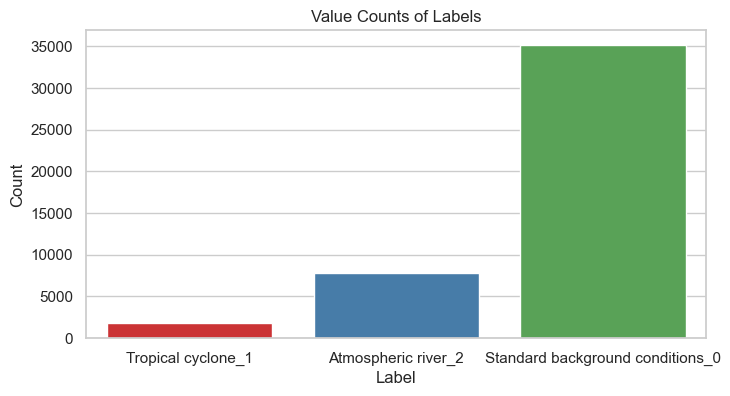

In [79]:
label_mapping = {
    0: 'Standard background conditions_0',
    1: 'Tropical cyclone_1',
    2: 'Atmospheric river_2'
}

# Map the label codes to custom label names
custom_labels = df['Label'].map(label_mapping)

# Create a bar plot
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x=custom_labels, palette='Set1')  # You can change the palette
plt.title('Value Counts of Labels')
plt.ylabel('Count')

plt.show()

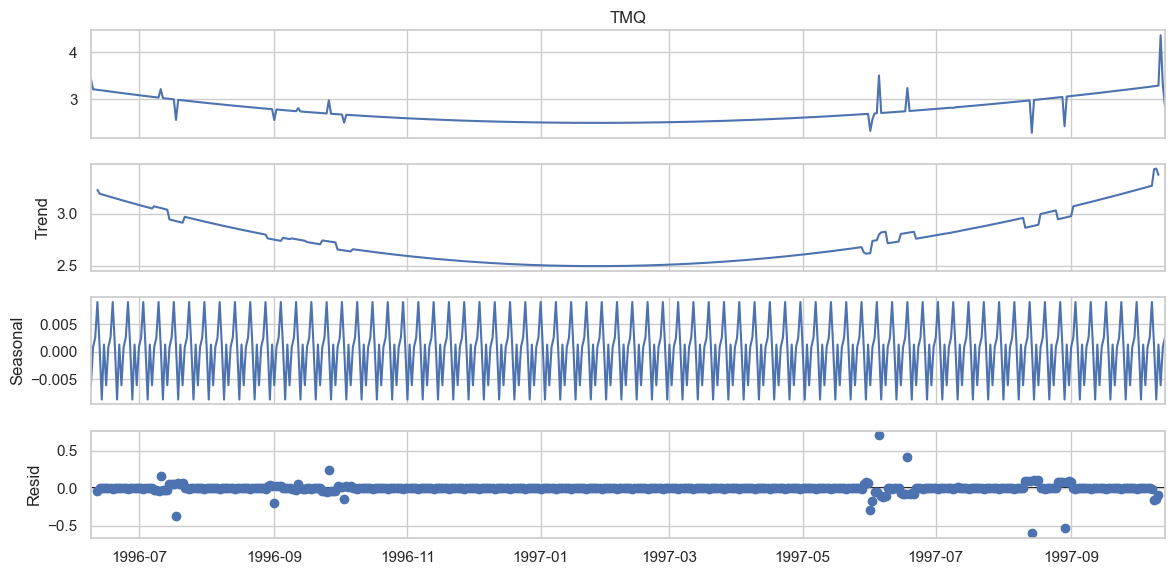

In [88]:
plt.rc('figure', figsize=(12, 6))
plt.rc('font', size=15)

data = df[(df.index.year.isin([1996,1997]))]
mean_resampled_data = data.resample('D').mean()
std_resampled_data = data.resample('D').std()

standardized_data = mean_resampled_data / std_resampled_data

# Handle any missing data
standardized_data = standardized_data.interpolate(method='spline', order=3)
result = seasonal_decompose(standardized_data['TMQ'], model='additive')
fig = result.plot()



# Submission Modelling

In [142]:
logreg = LogisticRegression(num_epochs=1000,
                            learning_rate=0.01,
                            regularization="L2", 
                            lambda_reg=0.1, 
                            gamma=2)

In [143]:
# Define CV strategy on the basis of the 'time' column where the last year is used as the test set
val_year = 2009
(X_train, y_train, X_val), y_val= preprocess(train=df.loc[df.index.year!=val_year],
                                      test=df.loc[df.index.year==val_year].drop(columns=['Label']),
                                    standardize=True),df.loc[df.index.year==2009,'Label']

In [144]:
logreg.fit(X = X_train.values, 
            y = y_train.values,
            X_val = X_val.values,
            y_val = y_val.values)

Epoch 0, Loss: 10784.226324951127, Train Accuracy: 0.3528403194513378, Val Accuracy: 0.27208333333333334
Epoch 100, Loss: 5784.209682755313, Train Accuracy: 0.7739926905202364, Val Accuracy: 0.7929166666666667
Epoch 200, Loss: 5062.043356336644, Train Accuracy: 0.7764743040202139, Val Accuracy: 0.8175
Epoch 300, Loss: 4706.356623843071, Train Accuracy: 0.7780535126111086, Val Accuracy: 0.8179166666666666
Epoch 400, Loss: 4490.566890083076, Train Accuracy: 0.7784144745747417, Val Accuracy: 0.8179166666666666
Epoch 500, Loss: 4344.106594840035, Train Accuracy: 0.7787754365383748, Val Accuracy: 0.8175
Epoch 600, Loss: 4237.225801063251, Train Accuracy: 0.7788205567838289, Val Accuracy: 0.8170833333333334
Epoch 700, Loss: 4155.2190477178965, Train Accuracy: 0.7795424807110951, Val Accuracy: 0.8170833333333334
Epoch 800, Loss: 4089.9664879696006, Train Accuracy: 0.780174164147453, Val Accuracy: 0.8158333333333333
Epoch 900, Loss: 4036.595952626313, Train Accuracy: 0.7807607273383568, Val Ac

In [145]:
get_classification_report(y_val, logreg.predict(X_val.values))

1. The F-1 score of the model 0.4673821066142183

2. The recall score of the model 0.4514736409149041

3. Classification report 
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1836
           1       0.00      0.00      0.00       112
           2       0.78      0.38      0.51       452

    accuracy                           0.82      2400
   macro avg       0.53      0.45      0.47      2400
weighted avg       0.77      0.82      0.78      2400
 

4. Confusion matrix 
 [[1784    2   50]
 [ 112    0    0]
 [ 279    0  173]] 



# Submission

In [147]:
df_test = pd.read_csv('data/test.csv',parse_dates=['time']).set_index('time').sort_index()

In [148]:
X_train, y_train, X_sub= preprocess(train=df,test=df_test.drop('SNo',axis=1),standardize=True)

In [ ]:
config = {
  "num_epochs": 1000,
  "learning_rate": 0.01,
  "regularization": "L2",
  "lambda_reg": 0.01,
  "gamma": 2.0
}
wandb.config.update(config)

logreg.fit(X = X_train.values, 
            y = y_train.values,
            validation=False)


In [149]:
y_sub = logreg.predict(X_sub.values)

In [150]:
sub = pd.DataFrame({'SNo':df_test['SNo'],'Label':y_sub})
sub.to_csv('data/20231101_2112_submission.csv',index=False)

In [ ]:
# Create a map centered around the mean of the latitude and longitude data
m = folium.Map(location=[df_test['lat'].mean(), df_test['lon'].mean()], zoom_start=4)

# Creating the heatmap
heat_data = [[row['lat'], row['lon'], row['PS']] for index, row in df_test.iterrows()]
HeatMap(heat_data).add_to(m)

m.save('map_test.html')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(df[['lat','lon']], dbscan.labels_)

new_data = df_test[['lat','lon']]
df_test['Region'] = knn.predict(new_data)